In [1]:
import numpy as np
import glob2
import datetime
from pathlib import Path
from tqdm.notebook import tqdm
import pickle
from matplotlib import pyplot as plt
from utils.detection.association_geodesic import squarize
plt.rcParams.update({'font.size': 18})
import math

from utils.data_reading.sound_data.station import StationsCatalog
from utils.physics.sound_model.spherical_sound_model import GridSphericalSoundModel as GridSoundModel, MonthlyHomogeneousSphericalSoundModel as HomogeneousSoundModel
from utils.detection.association_geodesic import compute_candidates, update_valid_grid, update_results, load_detections, compute_grids

## Parameters initialization

In [78]:
# paths
CATALOG_PATH = "/media/plerolland/akoustik"
dataset = "MAHY0"
DETECTIONS_DIR = f"../../../../data/detection/i_TiSSNet_raw_OBS-fixed/{dataset}"
SOUND_MODEL_PATH = f"../../../../data/sound_model"

# Detections loading parameters
MIN_P_TISSNET_PRIMARY = 0.3  # min probability of browsed detections
MIN_P_TISSNET_SECONDARY = 0.15  # min probability of detections that can be associated with the browsed one
MERGE_DELTA_S = 5 # threshold below which we consider two events should be merged
MERGE_DELTA = datetime.timedelta(seconds=MERGE_DELTA_S)

REQ_CLOSEST_STATIONS = 0  # The REQ_CLOSEST_STATIONS th closest stations will be required for an association to be valid

# sound model definition
STATIONS = StationsCatalog(CATALOG_PATH).filter_out_undated().filter_out_unlocated().by_dataset(dataset)
mid_pos = np.mean([s.get_pos() for s in STATIONS], axis=0)
SOUND_MODEL = HomogeneousSoundModel([f"{SOUND_MODEL_PATH}/min-velocities_month-{i:02d}.nc" for i in range(1,13)],
                                    mid_pos)

# association running parameters
SAVE_PATH_ROOT = None  # change this to save the grids as figures, leave at None by default

## Detections processing

In [79]:
STATIONS = StationsCatalog(CATALOG_PATH).filter_out_undated().filter_out_unlocated()
det_files = [f for f in glob2.glob(DETECTIONS_DIR + "/*.pkl") if Path(f).is_file()]
DETECTIONS = load_detections(det_files, STATIONS, 0.05, merge_delta=datetime.timedelta(seconds=MERGE_DELTA_S))

DETECTIONS_DIR_NAME = DETECTIONS_DIR.split("/")[-1]

Path(f"{DETECTIONS_DIR}/cache").mkdir(parents=True, exist_ok=True)
DET_PATH = f"{DETECTIONS_DIR}/cache/detections_{MIN_P_TISSNET_SECONDARY}_{MERGE_DELTA_S}.pkl"
if not Path(DET_PATH).exists():
    STATIONS = StationsCatalog(CATALOG_PATH).filter_out_undated().filter_out_unlocated()
    det_files = [f for f in glob2.glob(DETECTIONS_DIR + "/*.pkl") if Path(f).is_file()]
    DETECTIONS = load_detections(det_files, STATIONS, MIN_P_TISSNET_SECONDARY,
                                 merge_delta=datetime.timedelta(seconds=MERGE_DELTA_S))
    with open(DET_PATH, "wb") as f:
        pickle.dump((DETECTIONS), f)
else:
    with open(DET_PATH, "rb") as f:
        DETECTIONS = pickle.load(f)

idx_det = 0
IDX_TO_DET = {}
for idx, s in enumerate(DETECTIONS.keys()):
    s.idx = idx  # indexes to store efficiently the associations
    DETECTIONS[s] = list(DETECTIONS[s])
    for i in range(len(DETECTIONS[s])):
        DETECTIONS[s][i] = np.concatenate((DETECTIONS[s][i], [idx_det]))
        IDX_TO_DET[idx_det] = DETECTIONS[s][i]
        idx_det += 1
    DETECTIONS[s] = np.array(DETECTIONS[s])
DETECTION_IDXS = np.array(list(range(idx_det)))

STATIONS = [s for s in DETECTIONS.keys()]
FIRSTS_DETECTIONS = {s : DETECTIONS[s][0,0] for s in STATIONS}
LASTS_DETECTIONS = {s : DETECTIONS[s][-1,0] for s in STATIONS}

DETECTIONS_MERGED = np.concatenate([[(det[0], det[1], det[2], s) for det in DETECTIONS[s]] for s in STATIONS])
DETECTIONS_MERGED = DETECTIONS_MERGED[DETECTIONS_MERGED[:, 1] > MIN_P_TISSNET_PRIMARY]
DETECTIONS_MERGED = DETECTIONS_MERGED[np.argsort(DETECTIONS_MERGED[:, 1])][::-1]

Found 96448 detections for station MAHY0_MAHY01
Found 101127 detections for station MAHY0_MAHY02
Found 106543 detections for station MAHY0_MAHY03
Found 155880 detections for station MAHY0_MAHY04


## Grid computation

In [80]:
LAT_BOUNDS = [-13.4, -12.4]
LON_BOUNDS = [45.25, 46.25]
GRID_SIZE = 150  # number of points along lat axis
PICK_UNCERTAINTY = 1
SOUND_SPEED_UNCERTAINTY = 0.25
MAX_CLOCK_DRIFT = 0.1

GRID_PATH = f"{DETECTIONS_DIR}/cache/grids_{LAT_BOUNDS[0]}_{LAT_BOUNDS[1]}_{LON_BOUNDS[0]}_{LON_BOUNDS[1]}_{GRID_SIZE}_{PICK_UNCERTAINTY}_{SOUND_SPEED_UNCERTAINTY}_{MAX_CLOCK_DRIFT}.pkl"

if not Path(GRID_PATH).exists():
    GRID_TO_COORDS, TDoA, MAX_TDoA, TDoA_UNCERTAINTIES = compute_grids(LAT_BOUNDS, LON_BOUNDS, GRID_SIZE, SOUND_MODEL, STATIONS, pick_uncertainty=PICK_UNCERTAINTY, sound_speed_uncertainty=SOUND_SPEED_UNCERTAINTY, max_clock_drift=MAX_CLOCK_DRIFT)
    with open(GRID_PATH, "wb") as f:
        pickle.dump((GRID_TO_COORDS, TDoA, MAX_TDoA, TDoA_UNCERTAINTIES), f)
else:
    with open(GRID_PATH, "rb") as f:
        GRID_TO_COORDS, TDoA, MAX_TDoA, TDoA_UNCERTAINTIES = pickle.load(f)
GRID_TO_COORDS = np.array(GRID_TO_COORDS)

## Association
(note: parallelize this with e.g. ProcessPoolExecutor for large datasets)

In [81]:
print("starting association")
MIN_ASSOCIATION_SIZE = 3
ASSOCIATION_RECORD_TOLERANCE = 0
max_reached_per_det = {det_idx: MIN_ASSOCIATION_SIZE+ASSOCIATION_RECORD_TOLERANCE for det_idx in DETECTION_IDXS}


already_examined = set()

def process_detection(arg):
    detection, already_examined, max_reached_per_det = arg
    max_reached_per_det_modifications = {}
    local_association = []
    date1, p1, idx_det1, s1 = detection

    # list all other stations and sort them by distance from s1
    other_stations = np.array([s2 for s2 in STATIONS if s2 != s1
                               and date1 + datetime.timedelta(days=1) > FIRSTS_DETECTIONS[s2]
                               and date1 - datetime.timedelta(days=1) < LASTS_DETECTIONS[s2]])
    other_stations = other_stations[np.argsort([MAX_TDoA[s1][s2][date1.month - 1] for s2 in other_stations])]

    # given the detection date1 occurred on station s1, list all the detections of other stations that may be generated by the same source event
    current_association = {s1:(date1, idx_det1)}
    candidates = compute_candidates(other_stations, current_association, DETECTIONS, MAX_TDoA, MERGE_DELTA_S)

    # update the list of other stations to only include the ones having at least a candidate detection
    other_stations = [s for s in other_stations if len(candidates[s]) > 0]

    # define the recursive browsing function (that is responsible for browsing the search space of associations for s1-date1)
    def backtrack(station_index, current_association, valid_grid, associations):
        if station_index == len(other_stations):
            return
        station = other_stations[station_index]

        candidates = compute_candidates([station], current_association, DETECTIONS, MAX_TDoA, MERGE_DELTA_S)
        probabilities = [DETECTIONS[station][idx][1] for idx in candidates[station]]
        candidates[station] = np.array(candidates[station])[np.argsort(probabilities)][::-1][:10]
        for idx in candidates[station]:
            date, p, idx_det = DETECTIONS[station][idx]

            if date in already_examined:
                # the det was already browsed as main
                continue
            if len(other_stations) < max_reached_per_det[idx_det] - ASSOCIATION_RECORD_TOLERANCE - 1:
            # the det already belongs to an association larger that what we could have here
                continue

            valid_grid_new, dg_new = update_valid_grid(current_association, valid_grid, station, date, TDoA, TDoA_UNCERTAINTIES)

            valid_points_new = np.argwhere(valid_grid_new)[:, 0]

            if len(valid_points_new) > 0:
                current_association[station] = (date, idx_det)

                if np.all([len(current_association) >= max_reached_per_det[idx] - ASSOCIATION_RECORD_TOLERANCE for _, idx in
                       current_association.values()]):
                    update_results(date1, current_association, valid_points_new, local_association, TDoA, TDoA_UNCERTAINTIES)
                    for _, idx in current_association.values():
                        if len(current_association) > max_reached_per_det[idx]:
                            max_reached_per_det[idx] = len(current_association)
                            max_reached_per_det_modifications[idx] = len(current_association)
                backtrack(station_index + 1, current_association, valid_grid_new, associations)
                del current_association[station]
        # also try without self
        if station_index >= REQ_CLOSEST_STATIONS:
            backtrack(station_index + 1, current_association, valid_grid, associations)
        return

    if len(other_stations) >= max_reached_per_det[idx_det1]-ASSOCIATION_RECORD_TOLERANCE - 1:
        # we only browse other stations if we can make at least a trio
        backtrack(0, current_association, None, associations)
    return local_association, max_reached_per_det_modifications


frac = 0.1
n_chunks = math.ceil(1/frac)
chunk_size = len(DETECTIONS_MERGED) // n_chunks
chunks = [DETECTIONS_MERGED[i * chunk_size : (i + 1) * chunk_size] for i in range(n_chunks-1)]
chunks.append(DETECTIONS_MERGED[9 * chunk_size :])


# main part (note: process parallelization is a very efficient solution in case needed)
for i in range(len(chunks)):
    fname = f"{DETECTIONS_DIR}/cache/associations_{MIN_ASSOCIATION_SIZE}_{i*frac:.02f}.pkl"
    if Path(fname).exists():
        continue
    associations = []
    for det in tqdm(chunks[i]):
        local_association, max_reached_per_det_modifications = process_detection((det, already_examined, max_reached_per_det))
        already_examined.add(det[0])
        associations.extend(local_association)
        for i, v in max_reached_per_det_modifications.items():
            max_reached_per_det[i] = max(max_reached_per_det[i], max_reached_per_det_modifications[i])
    with open(fname, "wb") as f:
        pickle.dump(associations, f)

starting association


In [6]:
print(len(associations))

NameError: name 'associations' is not defined

# Associations plot

In [82]:
nb_per_coord = {n: {i:0 for i in range(len(GRID_TO_COORDS))} for n in range(0, 15)}

association_files = glob2.glob(f"{DETECTIONS_DIR}/cache/associations_{MIN_ASSOCIATION_SIZE}_*.pkl")
for file in association_files:
    with open(file, "rb") as f:
        associations = pickle.load(f)
    for association in tqdm(associations):
        detections, valid_points = association
        for i in valid_points:
            nb_per_coord[len(detections)].setdefault(i, 0)
            nb_per_coord[len(detections)][i] += 1

  0%|          | 0/4626 [00:00<?, ?it/s]

  0%|          | 0/3273 [00:00<?, ?it/s]

  0%|          | 0/2588 [00:00<?, ?it/s]

  0%|          | 0/2226 [00:00<?, ?it/s]

  0%|          | 0/1996 [00:00<?, ?it/s]

  0%|          | 0/2880 [00:00<?, ?it/s]

  0%|          | 0/2731 [00:00<?, ?it/s]

  0%|          | 0/2758 [00:00<?, ?it/s]

  0%|          | 0/2253 [00:00<?, ?it/s]

  0%|          | 0/2106 [00:00<?, ?it/s]

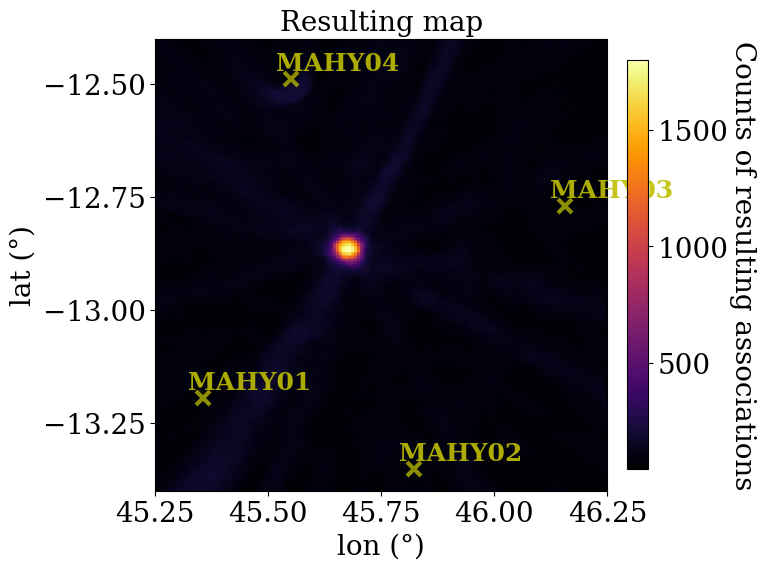

In [83]:
min_size_display = 3
log = False
weights = np.array([np.sum([nb_per_coord[n][i] for n in range(min_size_display,15)]) for i in range(len(GRID_TO_COORDS))])

fig, ax = plt.subplots(figsize=(8,8))
sq = squarize(GRID_TO_COORDS, weights, LAT_BOUNDS, LON_BOUNDS, size=1000)
if log:
    sq[sq<1] = 1
    sq = np.log10(sq)
#sq[sq<1.5] = 1.5
im = ax.imshow(sq[::-1], cmap="inferno",extent=(LON_BOUNDS[0], LON_BOUNDS[-1], LAT_BOUNDS[0], LAT_BOUNDS[-1]))
xticks = np.arange(np.floor(LON_BOUNDS[0]/0.25)*0.25, np.ceil(LON_BOUNDS[-1]/0.25)*0.25 + 0.25, 0.25)
yticks = np.arange(np.floor(LAT_BOUNDS[0]/0.25)*0.25, np.ceil(LAT_BOUNDS[-1]/0.25)*0.25 + 0.25, 0.25)
ax.set_xticks(xticks)
ax.set_yticks(yticks)

for s_ in STATIONS:
    p = s_.get_pos()

    if p[0] > LAT_BOUNDS[1] or p[0] < LAT_BOUNDS[0] or p[1] > LON_BOUNDS[1] or p[1] < LON_BOUNDS[0]:
        print(f"Station {s_.name} out of bounds")
        continue
    ax.plot(p[1], p[0], 'yx', alpha=0.75, markersize=10, markeredgewidth=3)
    ax.annotate(s_.name, xy=(p[1], p[0]), xytext=(p[1]-(LON_BOUNDS[1]-LON_BOUNDS[0])/30, p[0]+(LAT_BOUNDS[1]-LAT_BOUNDS[0])/50), textcoords="data", color='y', alpha=0.9, weight='bold')
cbar = plt.colorbar(im,fraction=0.0415, pad=0.04)
cbar.set_label(f'Counts of resulting associations{" (log)" if log else ""}', rotation=270, labelpad=20)
ax.set_title(f"Resulting map")
ax.set_xlabel("lon (°)")
ax.set_ylabel("lat (°)")
plt.tight_layout()
Path(f"{DETECTIONS_DIR}/figures").mkdir(exist_ok=True)
plt.savefig(f'{DETECTIONS_DIR}/figures/_min-{min_size_display}_{"log" if log else ""}.png', dpi=300, bbox_inches='tight')

In [84]:
kept = []
lats = [-12.75, -12.25]  #top left
lats = [-13, -12.75]  # center
lons = [45.9, 46.25]  # top left
lons = [45.4, 45.75]  # top right
lons = [45.5, 45.75]  # center

for association in tqdm(associations):
    detections, valid_points = association
    valid_points = np.array([GRID_TO_COORDS[i] for i in valid_points])
    if np.any((valid_points[:,0] > lats[0]) & (valid_points[:,0] < lats[1]) & (valid_points[:,1] > lons[0]) & (valid_points[:,1] < lons[1])):
        kept.append(detections)
print(len(kept))

  0%|          | 0/2106 [00:00<?, ?it/s]

353


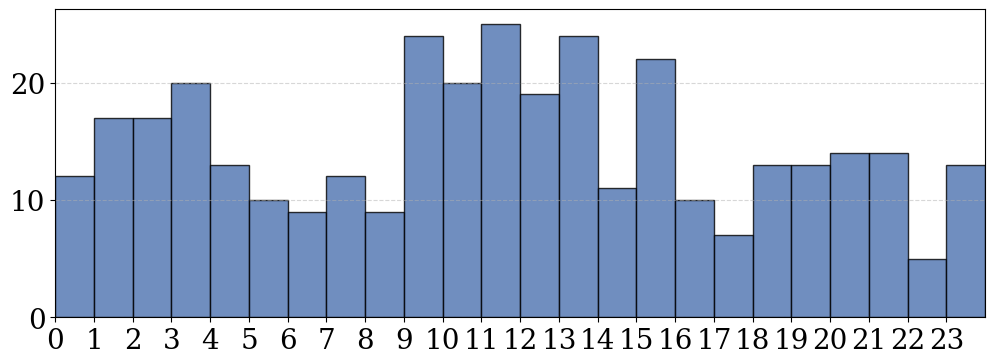

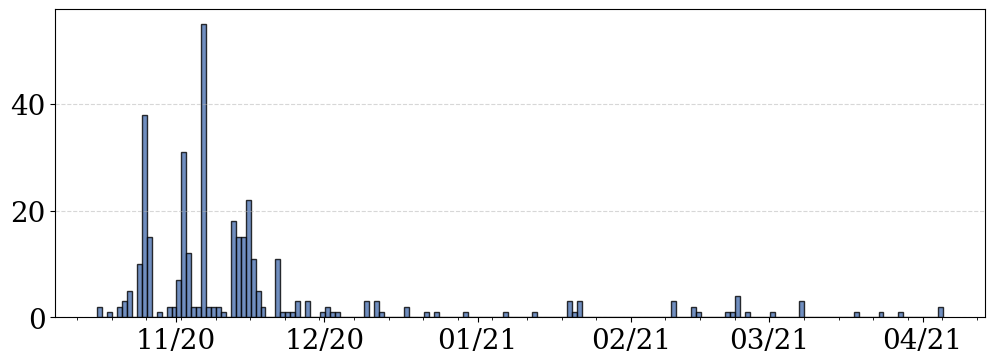

In [85]:
import matplotlib.dates as mdates

kept_dates = []
for k in kept:
    dates = []
    for si, pi in k:
        det = IDX_TO_DET[pi]
        dates.append(det[0])
    kept_dates.append(dates[0] + np.mean(np.array(dates[1:])-dates[0]))


# HOUR
hours = [dt.hour for dt in kept_dates]

plt.figure(figsize=(12, 4))
plt.hist(hours, bins=24, range=(0, 24), edgecolor='black', color="#4c72b0", alpha=0.8)

plt.xticks(np.arange(0, 24))
plt.xlim(0,24)
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.savefig(f'{DETECTIONS_DIR}/figures/hourly_{lats[0]}-{lats[1]}_{lons[0]}-{lons[1]}.png', dpi=300, bbox_inches='tight')



# DAY
kept_dates = sorted(kept_dates)

fig, ax = plt.subplots(figsize=(12, 4))

bin_width = datetime.timedelta(days=1)

min_date = min(kept_dates)
max_date = max(kept_dates)
n_bins = (max_date - min_date) // bin_width + 1
bins = [min_date + i * bin_width for i in range(n_bins + 1)]

ax.hist(kept_dates, bins=bins, edgecolor='black', color="#4c72b0", alpha=0.8)

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%y'))
ax.xaxis.set_minor_locator(mdates.WeekdayLocator(byweekday=mdates.MO))

ax.grid(axis='y', linestyle='--', alpha=0.5)

plt.savefig(f'{DETECTIONS_DIR}/figures/daily_{lats[0]}-{lats[1]}_{lons[0]}-{lons[1]}.png', dpi=300, bbox_inches='tight')

In [ ]:
from concurrent.futures import ProcessPoolExecutor
from utils.physics.signal.make_spectrogram import make_spectrogram

def process_event(idx_event):
    det = kept[idx_event]
    delta = datetime.timedelta(seconds=30)
    delta_s = delta.total_seconds()

    fig, axs = plt.subplots(len(det), figsize=(12, 30))
    for i, (s_idx, det_idx) in enumerate(det):
        manager = STATIONS[s_idx].get_manager()
        date = IDX_TO_DET[det_idx][0]
        data = manager.get_segment(date - delta, date + delta)
        f, t, spectro = make_spectrogram(
            data, manager.sampling_f, t_res=0.25, f_res=2,
            log=True, return_bins=True, normalize=True
        )
        axs[i].imshow(spectro, aspect="auto", cmap="inferno",
                      extent=(t[0] - delta_s, t[-1] - delta_s, f[0], f[-1]))
        axs[i].set_xlabel("time from detection (s)")
        axs[i].set_ylabel("frequency (Hz)")
        axs[i].set_title(f"Detection at time {date}, station {STATIONS[s_idx].name}")

    out_path = f"{DETECTIONS_DIR}/figures/spectros-asso_{lats[0]}-{lats[1]}_{lons[0]}-{lons[1]}/{idx_event}.png"
    plt.tight_layout()
    fig.savefig(out_path)
    plt.close(fig)

Path(f"{DETECTIONS_DIR}/figures/spectros-asso_{lats[0]}-{lats[1]}_{lons[0]}-{lons[1]}").mkdir(exist_ok=True)

with ProcessPoolExecutor(max_workers=6) as executor:
    list(tqdm(executor.map(process_event, range(len(kept))), total=len(kept)))